In [1]:
import cdsapi
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from datetime import datetime
from data_processing import *
from utils import utils_vision_data
import os
import warnings; warnings.simplefilter('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

## Get the data

In [25]:
#First we load the storms we are interested to work with
#Storms are begiining at different wind speeds, 
#so to standardize their beginning I cut them at a min_wind threshold they have to pass.
#Some storms don't have a lot of timesteps so you can specify with min_steps the minimum number of timesteps you want
#Some storms are 40 timesteps, others are 120, etc. So I cut them at a certain number of timesteps
min_wind = 50
min_steps = 20
max_steps=60
data = utils_vision_data.get_storms(min_wind = min_wind, min_steps= min_steps, max_steps=max_steps, extraction=True, path = './data/ibtracs.last3years.list.v04r00.csv')
#y represents the actual target data we are going to use
#y is of shape storms * timesteps * target features
y, _ = prepare_tabular_data_vision(min_wind = min_wind, min_steps= min_steps, max_steps=max_steps)
#Then we get their corresponding vision maps
vision_data = utils_vision_data.extract_vision(data, epsilon = 0.05)

The dictionary of storms has been created.
The trajectories have now been padded.
There are 84 storms with 9 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.
The dictionary of storms has been created.
The trajectories have now been padded.
There are 84 storms with 8 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.


In [14]:
#Let's visualize one example of y to understand its format
#y[0] is the timestamp
#y[1] is latitude
#y[2] is longitude
#y[3] is windspeed (intensity)
#y[4] is pressure
#y[5] is the latitude displacement with previous timestep
#y[6] is longitude displacement with previous timestep
y[0][0]

array(['2016-01-08 09:00:00', 6.38753, -171.692, 50.0, 995.5, 0.0, 0.0],
      dtype=object)

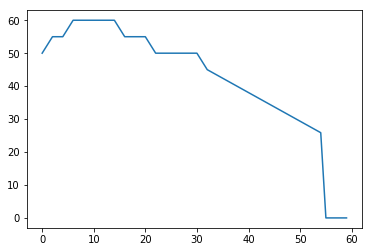

In [22]:
#one important remark: if the number of available timesteps is smaller than a threshold I pad with 0 the end.
#same with the vision data
plt.plot(y[15,:,3])
plt.show()

In [24]:
s = vision_data.shape
print(s)
#s[0] is the storm
#s[1] is the number of timesteps
#s[2] is the value field (geopotential, windspeed u, windspeed v)
#s[3] is the altitude 700, 500, 250
#s[4,5] is the actual map at this timestep, value, and altitude. 1 pixel is 1 degree of latitute and longitude
print("We have {} storms with {} timesteps.".format(s[0], s[1]))

(83, 60, 3, 3, 25, 25)
We have 83 storms with 60 timesteps.


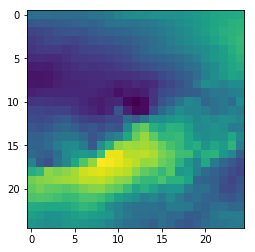

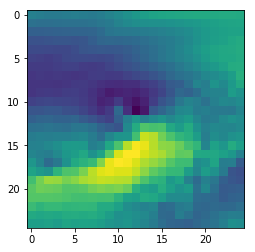

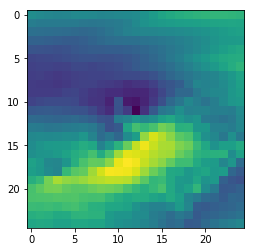

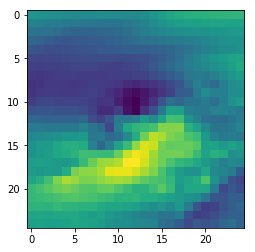

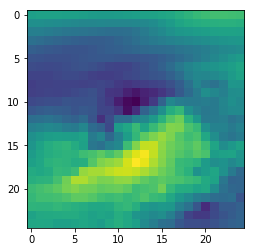

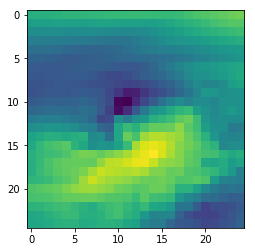

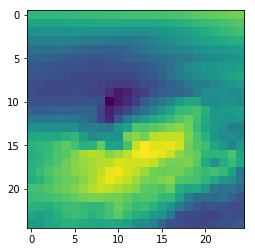

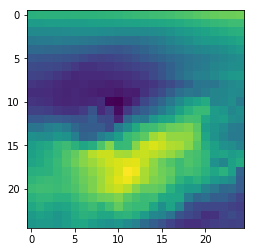

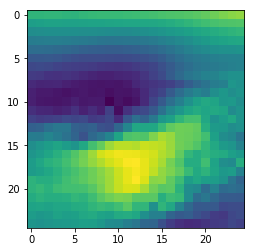

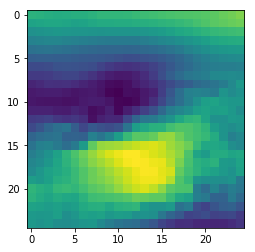

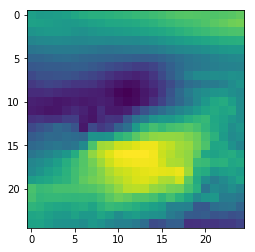

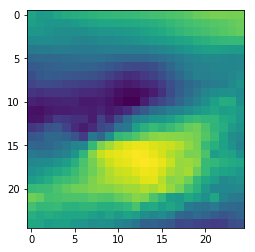

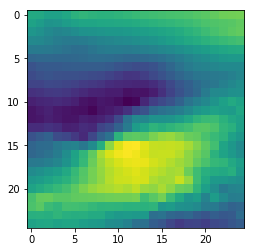

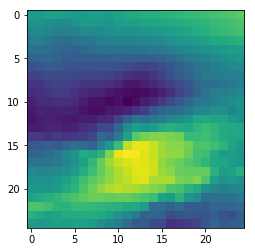

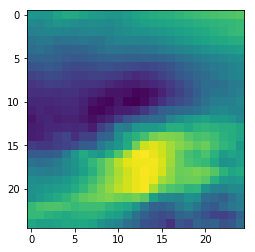

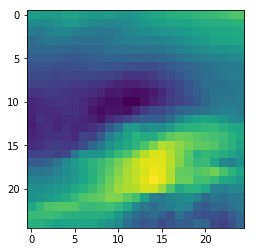

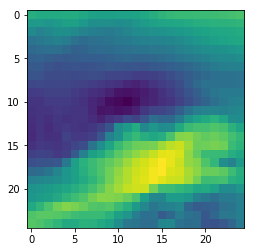

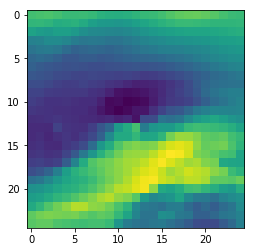

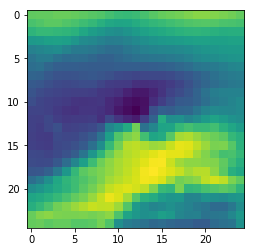

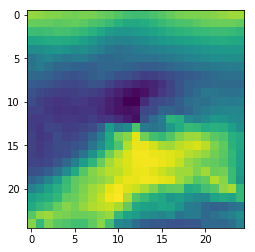

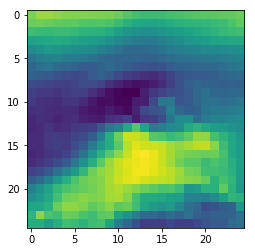

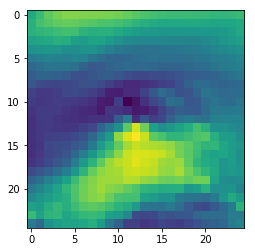

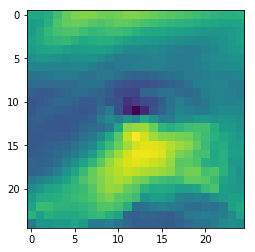

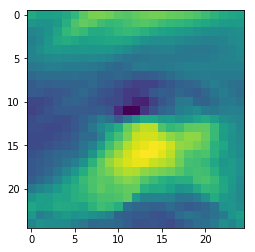

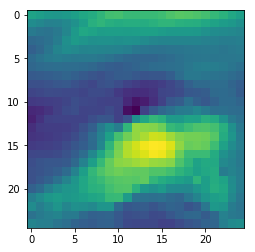

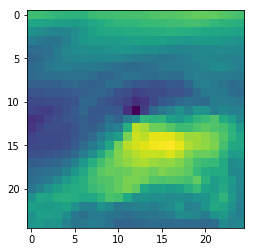

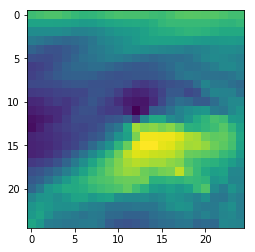

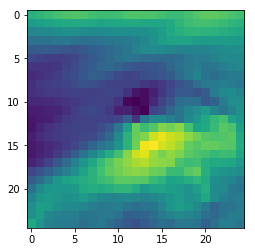

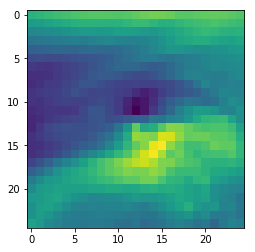

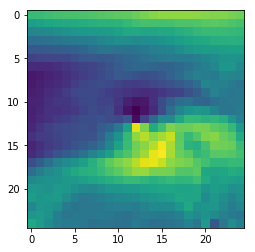

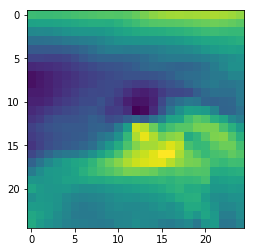

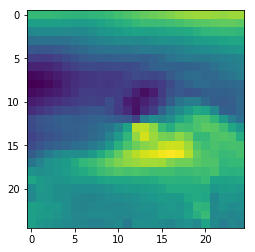

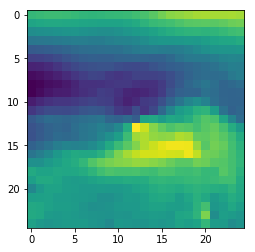

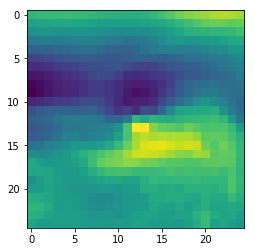

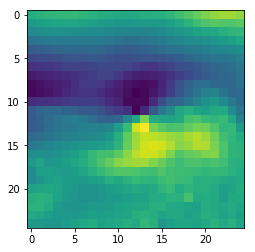

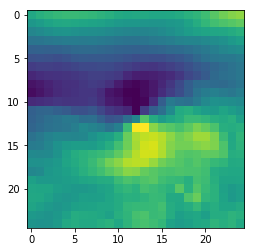

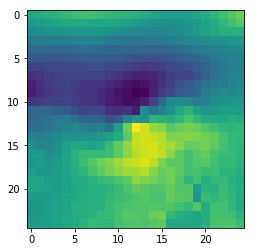

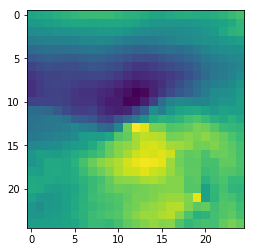

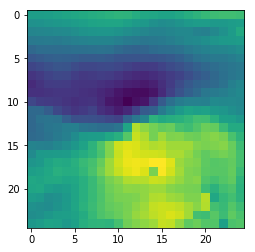

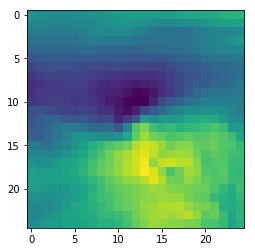

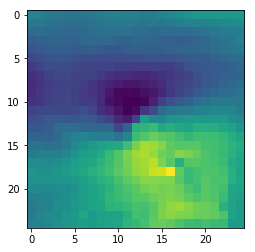

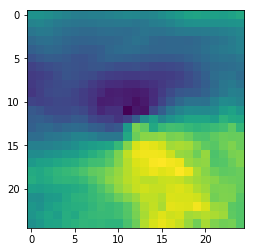

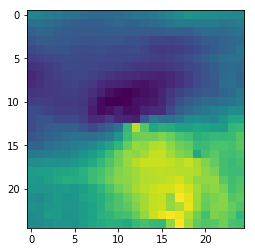

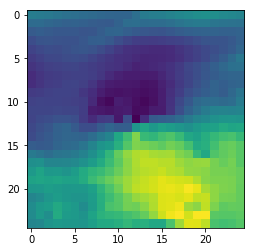

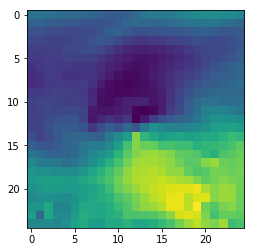

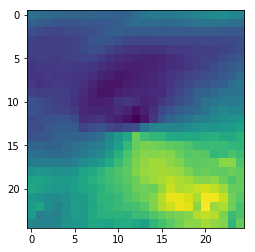

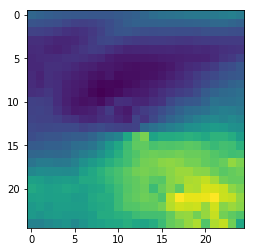

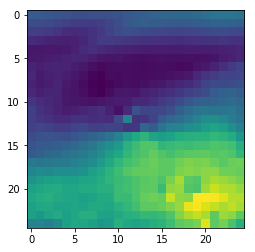

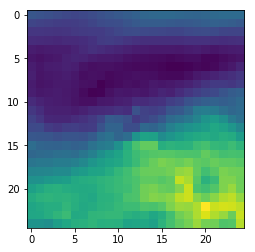

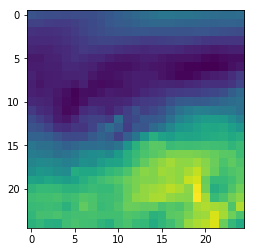

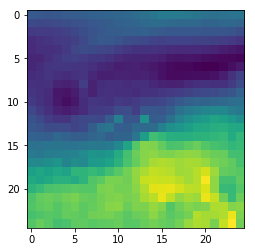

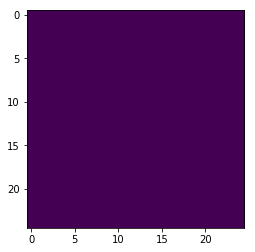

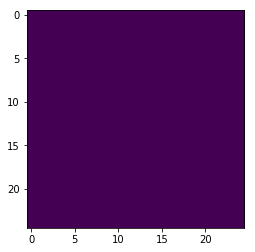

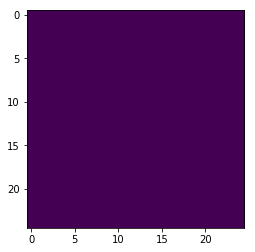

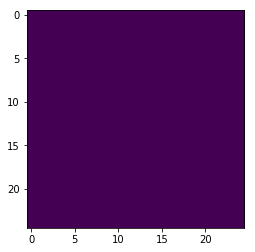

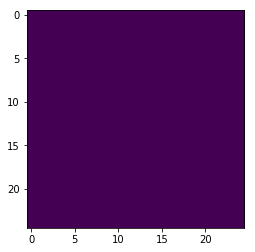

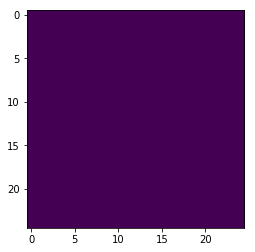

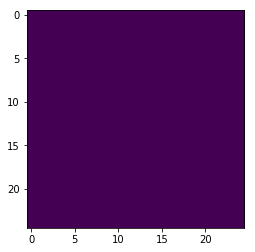

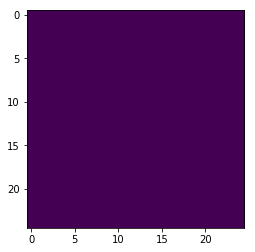

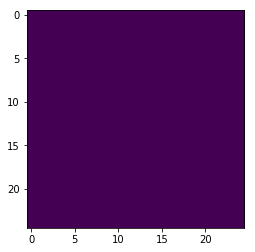

In [58]:
#I wanted to make a nice animation but I failed replotting on the same graph.
def animate():
    plt.ion()
    plt.figure()
    for i in range(60):
        data=vision_data[0, i, 0, 1]
        plt.imshow(data)
        plt.show()
        time.sleep(1)
        plt.clf()
animate()

## Visualize one map

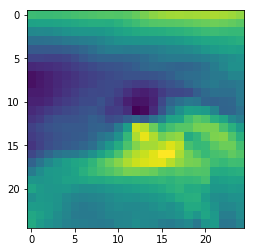

In [51]:
a = vision_data[0, 30, 0, 1]
plt.imshow(a)
plt.show()

# CNN Encoder

In [28]:
#The architecture I developed here is a CNN encoder followed by encoding Linear layers taking the CNN embedding.
# CNN Encoder
class EncoderCNN(nn.Module):
    def __init__(self, dropout = 0.5):
        super(EncoderCNN, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True

        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.init_weights()


    def init_weights(self):
        for idx, m in enumerate(self.modules()):
            if isinstance(m, nn.Conv2d) and idx==1:
                nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.bias,mean=0, std=1)
            if isinstance(m, nn.Conv2d) and idx!=1:
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
                nn.init.normal_(m.bias,mean=0, std=1)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = x.view(1, -1)
    
        return x
    
class EncoderLinear1(nn.Module):
    def __init__(self, rnn_decoder, dropout = 0.5):
        super(EncoderLinear1, self).__init__()

        self.fc1 = nn.Linear(in_features=256*4*4, out_features=576)
        self.fc1_bn = nn.BatchNorm1d(576)
        self.fc2 = nn.Linear(in_features=576, out_features=128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc3_bn = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(in_features=64, out_features=2)
        self.init_weights()
        self.rnn_decoder = rnn_decoder

    def init_weights(self):
        for idx, m in enumerate(self.modules()):
            if isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear) and idx==1:
                nn.init.xavier_normal_(m.weight, gain=1)
                nn.init.normal_(m.bias,mean=0, std=1)
            elif isinstance(m, nn.Linear) and idx!=1:
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
                nn.init.normal_(m.bias,mean=0, std=1)

    def forward(self, x):
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        if self.rnn_decoder:
            return x
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = self.fc4(x)
        return x

#complete encoder
class EncoderCNNLinear1(nn.Module):
    def __init__(self, dropout = 0.5, rnn_decoder = False):
        super(EncoderCNNLinear1, self).__init__()

        self.cnn = EncoderCNN()
        self.linear = EncoderLinear1(rnn_decoder)

    def forward(self, x):
        x = self.cnn(x)
        x = self.linear(x)
        return x

In [29]:
#This is the GRU Decoder
class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, dropout = 0.5):
        super(DecoderGRU, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size)

    def forward(self, inputs, hidden = None):
        if hidden is None:
            hidden = self.init_hidden(self.hidden_size)
        outputs, hiddens = self.rnn(inputs.unsqueeze(0), hidden)
        return outputs, hiddens

    def init_hidden(self, hidden_size):
        return torch.zeros((1, 1, hidden_size))

#Full EncoderDecoder    
class EncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_decoder = True, dropout = 0.5):
        super(EncoderDecoder, self).__init__()
        self.in_channels = 3 * 3
        #self.adjust_dim = False
       # if len(levellist) > 1 and len(params) >1:
            #self.adjust_dim = True
        self.hidden_size = hidden_size
        self.encoder = EncoderCNNLinear1(rnn_decoder=True)
        self.decoder = DecoderGRU(input_size, hidden_size)
        self.lastlinear = nn.Linear(hidden_size, 2)
        self.hidden = self.init_hidden(hidden_size)

    def forward(self, inputs, hidden = None):
        x = self.encoder(inputs)
        o, self.hidden = self.decoder(x, self.hidden)
        y = self.lastlinear(o)
        return y

    def init_hidden(self, hidden_size):
        return torch.zeros((1, 1, hidden_size))

## Test

In [31]:
#To test the model I take one storm and the first timestep.
test = torch.Tensor(vision_data[0,0]).reshape(1, 9, 25, 25)
e_d = EncoderDecoder(128, 128)
e_d.eval()
#Here the model outputs the displacement in x and y respective to the last timestep
e_d(test)

tensor([[[ 0.4193, -0.4846]]], grad_fn=<AddBackward0>)

## ConvLSTM cell

In [32]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [33]:
class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [38]:
c = ConvLSTM(input_dim = 9, hidden_dim=128, kernel_size=(3,3), num_layers=1, batch_first=True, bias = True)

In [39]:
s = vision_data.shape
v = vision_data.reshape(s[0], s[1], s[2]*s[3], s[4], s[5])
v = torch.Tensor(v)

In [40]:
c.eval()
outputs, last_states = c(v[0][:10].unsqueeze(0))

In [41]:
outputs[0][0].shape

torch.Size([10, 128, 25, 25])